<a href="https://colab.research.google.com/github/mikeysforte/NYU-IEP-2022-3-Classroom-Assignment1--mikeysforte-/blob/main/Michael_Forte_Checkpoint_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Run me first!

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import scipy.optimize

#Checkpoint 2: simulate a pendulum with variable damping

#Simulate a pendulum with variable drag force

##Remider: constant drag
In the last checkpoint, we introduced a drag force proportional to the velocity ($\vec{F}_{drag} = - \beta \vec{v}$) (I've changed $B \to \beta$ to avoid confusion with the magnetic field)

$\frac{d^2 x}{d t^2} = -\frac{g}{L} x - \frac{\beta}{m} \frac{d x}{d t}$

with the **substituion**

$s = \omega t$

we found

$\frac{d^2 x}{d s^2} = -x - \frac{\beta}{m \omega} \frac{d x}{d s}$

or as a system of equations: 

$\frac{d x}{d s} = u(s)$

$\frac{d u}{d s} = - x(s) - \frac{\beta}{m \omega} u(s)$

Translating the system into a vector:

$\vec{y}(s) = (x(s),u(s))$

$\frac{d \vec{y}}{d s} = (y_1(s), -y_0(s) - \frac{\beta}{m \omega} y_1(s))$

Using the definition $Q = \frac{m \omega}{\beta}$, we got the final form:

$\frac{d \vec{y}}{d s} = (y_1(s), -y_0(s) - y_1(s)/Q)$

This relation was implemented by the function `dampedOsicllatorDerivative` which you wrote as part of Checkpoint 1
```
def dampedOscillatorDerivative (s,y,Q):
  return (y[1],-y[0]-y[1]/Q)
```
##Variable drag

Now, I would like you to make the drag force depend on the separation of the bob from the aluminum disk. 

$\vec{F}_{drag} = - \beta(z) \vec{v}$

We can write $Q(z) \equiv \frac{m \omega}{\beta(z)}$ and follow the same derivation as for the constant $\beta$ case to find

$\frac{d \vec{y}}{d s} = (y_1(s), -y_0(s) - y_1(s)/Q(z))$



The separation depends on the displacement of the bob and the length of the pendulum. 

$z(x) = z_0 + \frac{1}{2}\frac{x^2}{L}$ (small angle approximation), where $z_0$ is the separation from the center of the magnet to the plate. 

We need to do modify `dampedOsicllatorDerivative` to 
  1. Calculate the separation ($z(x)$)
  1. Accept and use a *functional* argument `QofZ` that gives the instantaneous Q as a function of height. 

I want you to help write two new functions:

`ZofX (z0, L, x)` that calculates $z(x)$ and

`variableDampedOscillatorDerivative(s, y, z0, L, QofZ)` that implements the relation

$\frac{d \vec{y}}{d s} = (y_1(s), -y_0(s) - y_1(s)/Q(z))$


In [ ]:
def dampedOscillatorDerivative (s,y,Q):
  return (y[1],-y[0]-y[1]/Q) #last week's solution

#calculates height of bob (z) given rest height (z0), string length (L), and bob displacement (x)
def ZofX (z0, L, x):
  return z0 + 0.5 * x*x/L #DONE
#implements the relation dy/ds = (y1, -y0 - y1/Q(z))
#calculates z using z0, L, and y[0]

def variableDampedOscillatorDerivative (s, y, z0, L, QofZ):

  z = ZofX(z0, L, y[0]) #DONE

  Q = QofZ(z) #DONE
  return  (y[1],-y[0]-y[1]/Q)

##Write a general power law Q of z

Let's imagine that $\beta(z) \propto z^{-n}$. Then $Q(z) \propto z^n$. 

For instance, for a dipole over an infinitely thick metal sheet, it can be shown that $\beta(z) \propto z^{-3}$ and $Q(z) \propto z^3$. But I may want to test several power laws. So let's make it general. 

Say we know $Q = Q_{ref}$ at one separation $z_{ref}$, i.e. $Q(z_{ref}) = Q_{ref}$. Then if $Q(z) \propto z^n$, 

$Q(z) = Q_{ref}*(\frac{z}{z_{ref}})^n$

Please write a function `QPowerLaw(z, Qref, zref, n)` that implements this relation.  

In [ ]:
def QPowerLaw (z, Qref, zref, n):
  return  Qref*(z/zref)**n

#Write two specific power law functions to test

Just as a starting point, let's assume that $\beta(z) \propto z^{-3}$. Let's look back at lab 5 to find $Q_{ref}$ and $z_{ref}$. We'll use the measurements when the large bob was about 2 mm above the plate. Let's say the effective center of the magnet is about 3 mm above its bottom, so $z_{ref} = 2 + 3 = 5$ mm.  Looking at the data, the lifetime was about 9.5s. Since $Q = \omega \tau$ and $\omega \sim \pi$, this gives $Q_{ref} \sim 30$. 

1. Write a function `QLabGuess(z)` that calculates $Q(z) = 30*(\frac{z}{.005})^3$. **notice $z_{ref} = .005$ meters**. We'll use the meter as the unit of length throughout to avoid confusion. Your function should call `QPowerLaw` and be *very* straightforward to write

1. For comparison, we'd like to consider the case of constant drag. So I just want a function $Q(z) = 30$. You can define a function `Qconst(z)` that just returns 30, but instead I'd like you to write this using a `lambda` expression. 



In [ ]:
def QLabGuess (z):
  return QPowerLaw(z,30,.005,3)

Qconst = lambda q : 30


##Simulate the bob for $\sim$ 3 lifetimes at a separation of 2 mm

1.   List item

1.   List item
2.   List item


2.   List item



We plan to work in dimensionless time, $s = \omega t$. Since $Q = \omega \tau$, the range $t = 0... 3 \tau$ is equivalent to $s = 0...3 Q$. 

1. Use `solve_ivp` to integrate the variable damped harmonic oscillator from an initial condition $(0.1, 0)$ (10 cm displacement, 0 velocity), with the pendulum length = 1 meter, and $z_0 = 0.005$ (corresponding to 2 mm separation + 3mm to the bob center) using the `QLabGuess` force law. Store the result in `sol_variable`

1. The same, but for `QConst` force law. Store the result in `sol_const`

1. Calculate the energy for both solutions (e.g. `U_variable=0.5*(sol_variable.y[0]**2 + sol_variable.y[1]**2)`) and store them in `U_variable` and `U_const` respectively. 

1. For both solutions, plot the amplitude vs. s on one set of axes. On a separate set of axes, make a semi-log (linear s, log energy) of the total energy  vs. s. For both plots, label the axes and add a legend indicating variable and constant

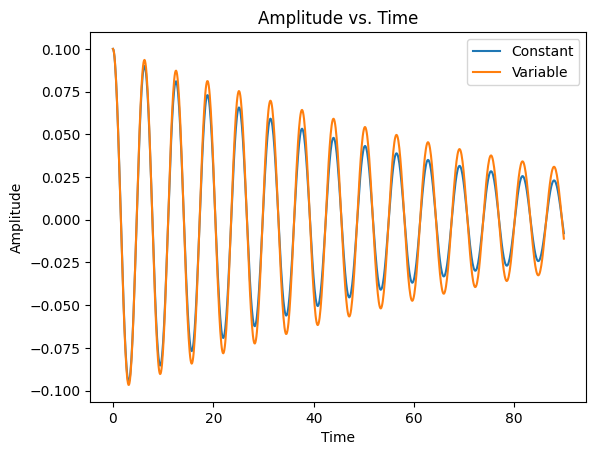

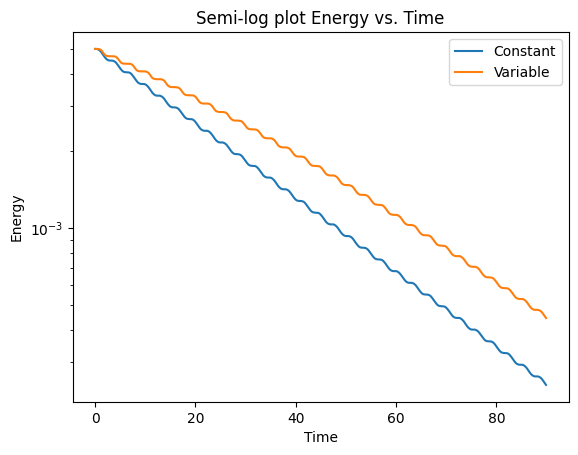

In [ ]:
init_amplitude = 0.1
L = 1
s_span = (0,90)
s_eval = np.arange(s_span[0], s_span[1], 0.1)
z0 = 0.005
y = (0.1,0)

sol_const = solve_ivp (variableDampedOscillatorDerivative, s_span, y, t_eval = s_eval, args=(z0,L,Qconst))
sol_variable = solve_ivp (variableDampedOscillatorDerivative, s_span, y, t_eval = s_eval, args=(z0,L,QLabGuess)) 

U_variable = 0.5*(sol_variable.y[0]**2 + sol_variable.y[1]**2)
U_const = 0.5*(sol_const.y[0]**2 + sol_const.y[1]**2)


plt.plot(sol_const.t,sol_const.y[0], label = 'Constant')
plt.plot(sol_variable.t, sol_variable.y[0], label = 'Variable')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Amplitude vs. Time')
plt.show()

plt.semilogy(sol_const.t, U_const, label = 'Constant')
plt.semilogy(sol_variable.t, U_variable, label = 'Variable')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.legend()
plt.title('Semi-log plot Energy vs. Time')
plt.show()

#Fit the energy loss to an exponential and find a lifetime

1. Use the `fitExponential` function from lab analysis 5 to find the best exponential model of $U = U(0)e^{-s/Q}$ for both the variable and constant damping. 

1. Plot the energies and their fits on a single set of semi-logarithmic axes and title the graphs with the non-dimensional fit lifetimes. (if $U = a e^{b s}$, then the non-dimensional lifetime is $-1/b$) The lifetime for the constant drag should equal the constant Q; the variable drag lifetime should be longer



39.85902389830282
29.88661909253698


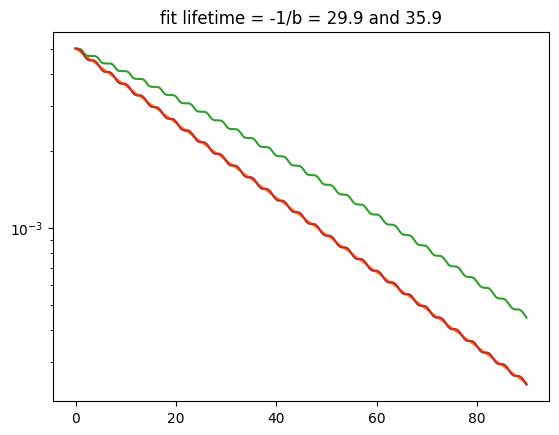

In [ ]:
# fitting an exponential
# exponential has two parameters, the y-intercept (a) and the
# exponential multiplier constant (b which for our purposes is -1/tau)
# inputs: x,y - numpy arrays
# outputs: a: fit value of y(0)
#          b: fit value of exonent
#          fity: a * e^(bx) 
def fitExponential(x,y):
  #rescale/recenter data so x starts at 0; y has max value of 1
  xx = x - np.min(x)
  yy = y / np.max(y)
  fitparams, *_ = scipy.optimize.curve_fit(lambda xdata, a, b : a*np.exp(b * xdata), xx, yy, (1, -1/max(xx)))
  a,b = fitparams
  a = a*np.max(y)*np.exp(-b*np.min(x)) #undo effects of rescaling, recentering
  print(-1/b)

  return (a,b, a*np.exp(b*x))


plt.title("fit lifetime = -1/b = 29.9 and 35.9")
fitvariable = fitExponential(s_eval,U_variable)
plt.semilogy(s_eval, U_const)
fitconst = fitExponential(s_eval,U_const)
plt.semilogy(s_eval, fitconst[2])
plt.semilogy(s_eval, U_variable, label = '')
plt.semilogy(s_eval, U_const)


#Find lifetime vs. initial separation for the variable oscillator

calculate the lifetime vs separation betwen 1 and 10 mm as follows

1. initialize empty list `lifetime = []`

1. define `height = np.arange(1,11)`

2. `for h in height:`
  1. calculate z0 ($h/1000 + .003$)
  1. calculate Q0 as `QLabGuess(z0)` - the lifetime for small oscillations that don't change the height much
  1. define `s_span` as `(0, 3*Q0)`
  1. define `s_eval` as 0, 0.1, 0.2 ... , 3*Q0
  1. use `solve_ivp` to integrate the variable damped oscillator (`variableDampedOscillatorDerivative`) with initial position 0.1, initial velocity 0, and extra arguments z0, L = 1 m, and QLabTest. Store the result in sol
  1. Calculate `U =0.5*(sol.y[0]**2 + sol.y[1]**2)`
  1. find the best fit exponential relation between `U` and `sol.t` $U = a e^{ b t}$
  1. append `-1/b` to `lifetime`

1. Convert lifetime to a numpy array and divide by $\omega = \pi s^{-1}$ to get a lifetime in seconds

1. Plot lifetime vs. h


[  6.87664002  12.68752136  21.03186787  32.36317308  47.12391753
  65.75136987  88.67256386 116.30439335 149.05119698 187.30050792]


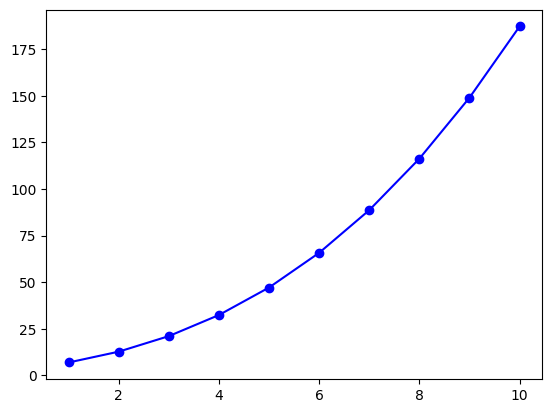

In [ ]:
lifetime=[]
height =np.arange(1,11)
L=1
for h in height:
  z0=(h/1000 + 0.003)
  Q0 = QLabGuess(z0)
  s_span= (0,3*Q0)
  s_eval=np.arange(s_span[0], s_span[1], .1)
  sol=solve_ivp(variableDampedOscillatorDerivative, s_span, y, t_eval=s_eval, args= (z0,L,QLabGuess))
  U=.5*(sol.y[0]**2 +sol.y[1]**2)
  fitU= fitExponential(sol.t, U)
  lifetime.append(-1/fitU[1])
  
life=np.array(lifetime)/np.pi
print(life)
plt.plot(height,life, 'b-o')